<a href="https://colab.research.google.com/github/dilphinnj/Algorithms/blob/main/Cust_Sentiment_Analysis_ML_upd.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install xgboost if you don't have it
# pip install xgboost

import xgboost as xgb
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import os
import pandas as pd
import numpy as np
from sklearn.impute import KNNImputer
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# os.chdir("C:\Dilip\AdvancedML\Adv_ML_project")
df_orig = pd.read_csv("ecommerce_customer_data.csv")

# 1. EDA

In [ ]:
df_orig.head(5)

,Order_ID,Customer_ID,Date,Age,Gender,City,Product_Category,Unit_Price,Quantity,Discount_Amount,Total_Amount,Payment_Method,Device_Type,Session_Duration_Minutes,Pages_Viewed,Is_Returning_Customer,Delivery_Time_Days,Customer_Rating
0,ORD_000001-1,CUST_00001,2023-05-29,40.0,Male,Ankara,Books,29.18,1,0.00,29.18,Digital Wallet,Mobile,14.0,9,True,13,4
1,ORD_000001-2,CUST_00001,2023-10-12,40.0,Male,Ankara,Home & Garden,644.40,1,138.05,506.35,Credit Card,Desktop,14.0,8,True,6,2
2,ORD_000001-3,CUST_00001,2023-12-05,40.0,Male,Ankara,Sports,332.82,5,0.00,1664.10,Credit Card,Mobile,15.0,10,True,9,4
3,ORD_000002-1,CUST_00002,2023-05-11,NaN,Male,Istanbul,Food,69.30,5,71.05,275.45,Digital Wallet,Desktop,16.0,13,True,4,4
4,ORD_000002-2,CUST_00002,2023-06-16,33.0,Male,Istanbul,Beauty,178.15,3,0.00,534.45,Credit Card,Mobile,14.0,7,True,6,4


In [ ]:
df_orig.shape

(17049, 18)

In [ ]:
df = df_orig
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17049 entries, 0 to 17048
Data columns (total 18 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Order_ID                  17049 non-null  object 
 1   Customer_ID               17049 non-null  object 
 2   Date                      17049 non-null  object 
 3   Age                       15345 non-null  float64
 4   Gender                    17049 non-null  object 
 5   City                      17049 non-null  object 
 6   Product_Category          17049 non-null  object 
 7   Unit_Price                17049 non-null  float64
 8   Quantity                  17049 non-null  int64  
 9   Discount_Amount           17049 non-null  float64
 10  Total_Amount              17049 non-null  float64
 11  Payment_Method            17049 non-null  object 
 12  Device_Type               17049 non-null  object 
 13  Session_Duration_Minutes  15345 non-null  float64
 14  Pages_

In [ ]:
numeric_columns = ['Unit_Price','Quantity','Discount_Amount','Total_Amount','Session_Duration_Minutes','Pages_Viewed','Delivery_Time_Days']
categorical_columns = ['Gender','City','Product_Category','Device_Type','Is_Returning_Customer','Customer_Rating']

In [ ]:
cols_to_impute = ["Age", "Session_Duration_Minutes"]

imputer = KNNImputer(n_neighbors=3)

# Fit only on selected columns
df_imputed = df.copy()
df_imputed[cols_to_impute] = imputer.fit_transform(df[cols_to_impute])

In [ ]:
# 1. Load dataset
data = df_imputed

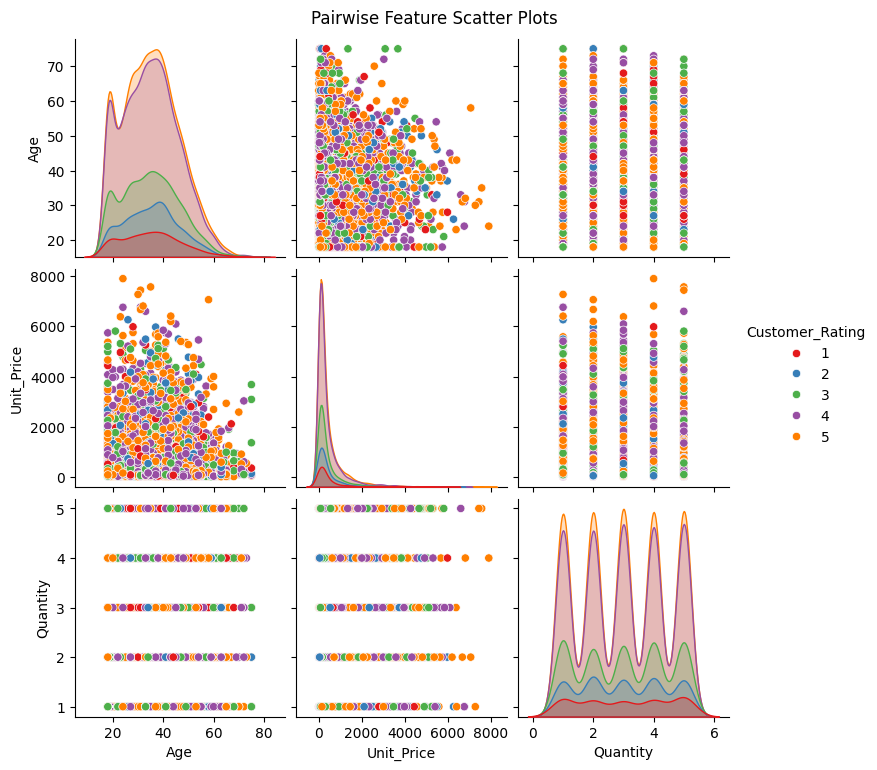

In [ ]:
# Pairplot to visualize pairwise relationships

# Define columns to plot
columns_to_plot = ['Age', 'Unit_Price', 'Quantity']  # select only a subset
df_subset = df[columns_to_plot + ['Customer_Rating']]

sns.pairplot(df_subset, hue='Customer_Rating', diag_kind='kde', palette='Set1')
plt.suptitle("Pairwise Feature Scatter Plots", y=1.02)
plt.show()

In [ ]:
import numpy as np

corr_matrix = df.corr(numeric_only=True).abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Features with correlation > 0.8
high_corr = [column for column in upper.columns if any(upper[column] > 0.8)]
print("Highly correlated features:", high_corr)


Highly correlated features: ['Total_Amount']


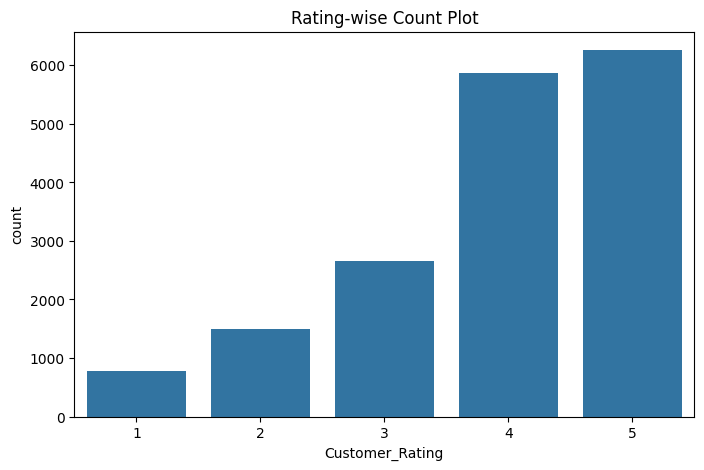

In [ ]:
plt.figure(figsize=(8,5))
sns.countplot(x='Customer_Rating', data=data)
plt.title("Rating-wise Count Plot")
plt.show()

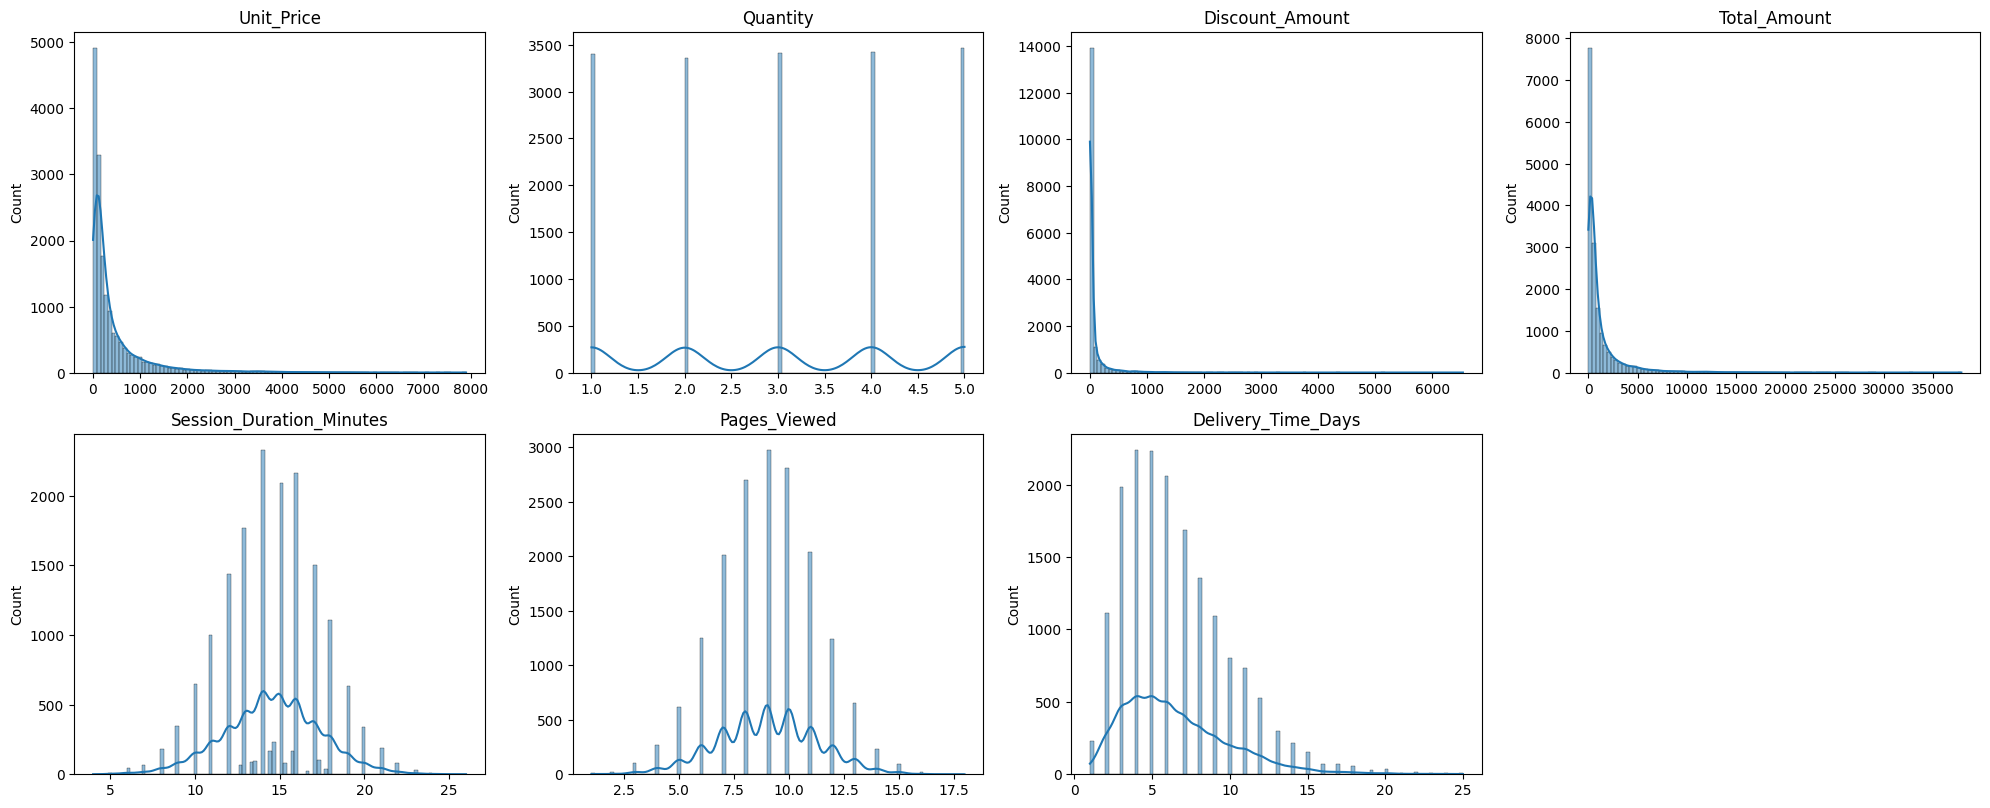

In [ ]:
def plot_histograms(df, columns, rows=2, cols=3):

    # df = df_orig01

    fig, axes = plt.subplots(rows, cols, figsize=(5*cols, 4*rows))
    axes = axes.flatten()

    for i, col in enumerate(columns):
        if i < len(axes):
            sns.histplot(df[col], kde=True, ax=axes[i], bins=100)
            axes[i].set_title(col)
            axes[i].set_xlabel('')

    for j in range(i+1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

plot_histograms(data, numeric_columns, rows=5, cols=4)

In [ ]:
from sklearn.preprocessing import LabelEncoder

# LabelEncoder
le = LabelEncoder()

# Encode the 'returned' column
# data['Date'] = le.fit_transform(data['Date'])
data['Gender'] = le.fit_transform(data['Gender'])
data['City'] = le.fit_transform(data['City'])
data['Product_Category'] = le.fit_transform(data['Product_Category'])
data['Payment_Method'] = le.fit_transform(data['Payment_Method'])
data['Device_Type'] = le.fit_transform(data['Device_Type'])
data['Is_Returning_Customer'] = le.fit_transform(data['Is_Returning_Customer'])
data["Date"] = pd.to_datetime(data["Date"])
data["Year"] = data["Date"].dt.year
data["Month"] = data["Date"].dt.month
data["DayOfWeek"] = data["Date"].dt.dayofweek

# # Features & target
data = data.drop(['Order_ID', 'Customer_ID', 'Date'], axis=1)

In [ ]:
y = data['Customer_Rating']
y = y-1
X = data.drop('Customer_Rating', axis=1)   # 0, 1, 2 → 3 classes

In [ ]:
y.shape

(17049,)

### Using SMOTE to balance the imbalance classes

In [ ]:
# Install if not already
# pip install imbalanced-learn

from imblearn.over_sampling import SMOTE
from collections import Counter

# X = features, y = target
print("Before SMOTE:", Counter(y))

# Initialize SMOTE
smote = SMOTE(random_state=42)

# Apply SMOTE
X_res, y_res = smote.fit_resample(X, y)

print("After SMOTE:", Counter(y_res))


Before SMOTE: Counter({4: 6260, 3: 5863, 2: 2658, 1: 1487, 0: 781})
After SMOTE: Counter({3: 6260, 1: 6260, 4: 6260, 2: 6260, 0: 6260})


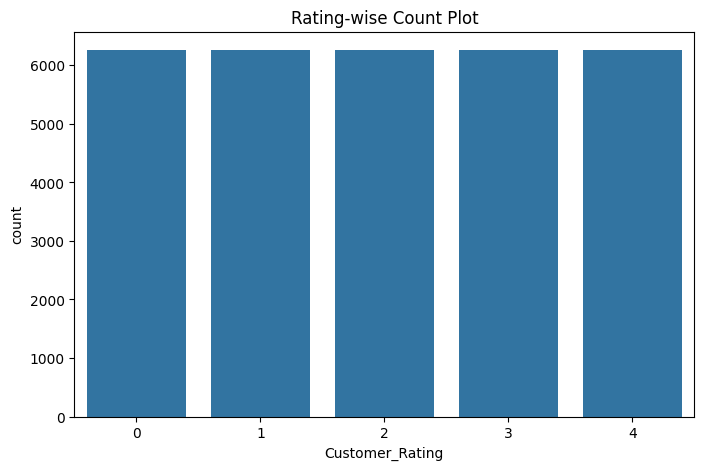

In [ ]:
# after smote

data_smt = pd.DataFrame(y_res)

plt.figure(figsize=(8,5))
sns.countplot(x='Customer_Rating', data=data_smt)
plt.title("Rating-wise Count Plot")
plt.show()

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17049 entries, 0 to 17048
Data columns (total 18 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Age                       17049 non-null  float64
 1   Gender                    17049 non-null  int64  
 2   City                      17049 non-null  int64  
 3   Product_Category          17049 non-null  int64  
 4   Unit_Price                17049 non-null  float64
 5   Quantity                  17049 non-null  int64  
 6   Discount_Amount           17049 non-null  float64
 7   Total_Amount              17049 non-null  float64
 8   Payment_Method            17049 non-null  int64  
 9   Device_Type               17049 non-null  int64  
 10  Session_Duration_Minutes  17049 non-null  float64
 11  Pages_Viewed              17049 non-null  int64  
 12  Is_Returning_Customer     17049 non-null  int64  
 13  Delivery_Time_Days        17049 non-null  int64  
 14  Custom

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X_res, y_res, test_size=0.2, random_state=42
)

In [ ]:
print(X_res.shape)
print(y_res.shape)
print(X_test.shape)
print(y_test.shape)

(31300, 17)
(31300,)
(6260, 17)
(6260,)


In [ ]:

# # 3. Convert to DMatrix
# dtrain = xgb.DMatrix(X_train, label=y_train, enable_categorical=True)
# dtest = xgb.DMatrix(X_test, label=y_test, enable_categorical=True)

# # 4. XGBoost parameters for MULTICLASS
# params = {
#     'learning_rate': 0.2,
#     'n_estimators':500,
#     'objective': 'multi:softprob',   # probability output
#     "num_class": y.max() + 1,                 # number of classes
#     'eval_metric': 'mlogloss',
#     'eta': 0.5,
#     'max_depth': 19
# }

# # 5. Train model
# model = xgb.train(params, dtrain, num_boost_round=50)

# # 6. Predict
# y_pred_proba = model.predict(dtest)
# y_pred = y_pred_proba.argmax(axis=1)   # choose class with highest prob

# # 7. Evaluate
# print("Accuracy:", accuracy_score(y_test, y_pred))
# # print("\nClassification Report:\n", classification_report(y_test, y_pred))


### Classifying with Xgboost

In [ ]:
# from xgboost import XGBClassifier
# from sklearn.model_selection import GridSearchCV

# # Parameters to tune
# param_grid = {
#     'learning_rate': [0.01, 0.05, 0.1, 0.2],
#     'n_estimators': [300, 500, 800],
#     'max_depth': [8, 9, 10]
# }

# # Grid Search
# grid = GridSearchCV(
#     estimator=xgbc,
#     param_grid=param_grid,
#     scoring='accuracy',
#     cv=3,
#     n_jobs=-1,
#     verbose=1
# )

# grid.fit(X_train, y_train)

# print("Best Params:", grid.best_params_)
# print("Best Accuracy:", grid.best_score_)


In [ ]:
from xgboost import XGBClassifier

# Base model
xgbc = XGBClassifier(
    learning_rate= 0.1,
    n_estimators= 500,
    objective= 'multi:softprob',   # probability output
    num_class= y.max() + 1,                 # number of classes
    eval_metric= 'mlogloss',
    # 'eta': 0.5,
    max_depth= 9
)

# Fit the model
xgbc.fit(X_train, y_train)

# Make predictions
xg_y_pred = xgbc.predict(X_test)

# 7. Evaluate
print("Accuracy:", accuracy_score(y_test, xg_y_pred))

Accuracy: 0.6301916932907349


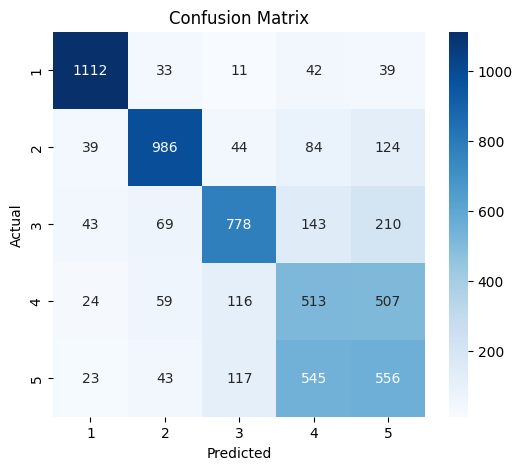

In [ ]:
from sklearn.metrics import confusion_matrix

cm_xg = confusion_matrix(y_test, xg_y_pred)
# Optional: class names
classes = ['1', '2', '3','4','5']

# Plot heatmap
plt.figure(figsize=(6,5))
sns.heatmap(cm_xg, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
from sklearn.model_selection import learning_curve
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import numpy as np

def plot_learning_curve(model, X, y, title):
    train_sizes, train_scores, val_scores = learning_curve(
        model, X, y, cv=5, scoring='accuracy',
        train_sizes=np.linspace(0.1, 1.0, 5)
    )

    train_mean = train_scores.mean(axis=1)
    val_mean = val_scores.mean(axis=1)

    plt.figure()
    plt.plot(train_sizes, train_mean, label="Training score")
    plt.plot(train_sizes, val_mean, label="Validation score")
    plt.title(title)
    plt.xlabel("Training Samples")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True)
    plt.show()

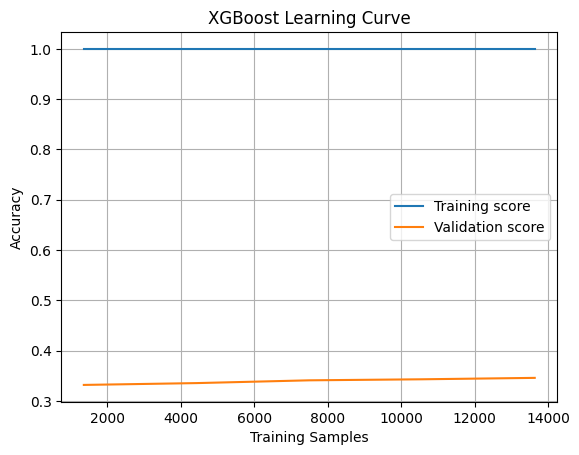

In [ ]:
plot_learning_curve(xgbc, X, y, "XGBoost Learning Curve")


In [ ]:
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score
from sklearn.datasets import load_iris


# 5-fold cross-validation
scores = cross_val_score(xgbc, X, y, cv=5, scoring='accuracy')
print("Cross-validation accuracy scores:", scores)
print("Mean accuracy:", scores.mean())


Cross-validation accuracy scores: [0.34017595 0.35542522 0.3398827  0.35777126 0.34291581]
Mean accuracy: 0.347234188610621


### Random forest classification for all 5 classes

In [ ]:
rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=42
)

rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print("Accuracy:", accuracy_score(y_test, y_pred))

importances = pd.Series(rf.feature_importances_, index=X.columns)
importances.sort_values(ascending=False).plot(kind='bar', figsize=(10,5))
plt.title("Feature Importances")
plt.show()



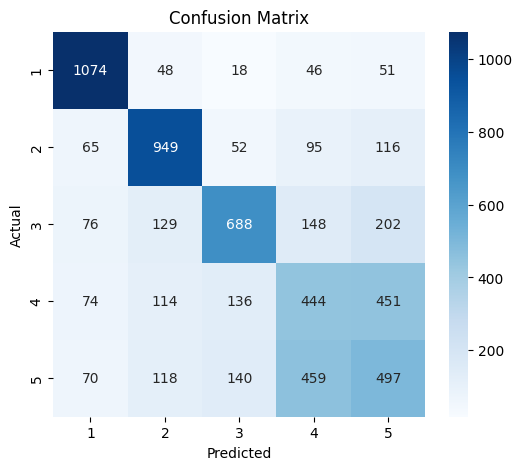

In [ ]:
cm = confusion_matrix(y_test, y_pred)
# Optional: class names
classes = ['1', '2', '3','4','5']

# Plot heatmap
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# # Grid search

# from sklearn.ensemble import RandomForestClassifier
# from sklearn.model_selection import GridSearchCV
# from sklearn.metrics import accuracy_score

# # Define the model
# rf = RandomForestClassifier(random_state=42)

# # Parameter grid (regularization + important RF params)
# param_grid = {
#     'n_estimators': [100, 200, 300],
#     'max_depth': [None, 5, 10, 15],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4, 6],
#     'max_features': ['sqrt', 'log2'],
# }

# # Grid search with 5-fold CV
# grid_search = GridSearchCV(
#     estimator=rf,
#     param_grid=param_grid,
#     cv=5,
#     scoring='accuracy',
#     n_jobs=-1,
#     verbose=1
# )

# grid_search.fit(X_train, y_train)


### Randomforest Classifier for 3 classes

In [ ]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    classification_report,
    confusion_matrix,
)

# ============================================
# 1) FEATURE ENGINEERING
# ============================================

df_fe = df.copy()

# Parse dates and derive features
df_fe["Date"] = pd.to_datetime(df_fe["Date"])
df_fe["Year"] = df_fe["Date"].dt.year
df_fe["Month"] = df_fe["Date"].dt.month
df_fe["DayOfWeek"] = df_fe["Date"].dt.dayofweek

# Drop IDs & raw date
df_fe = df_fe.drop(columns=["Order_ID", "Customer_ID", "Date"])

# --------------------------------------------
# Recode Customer_Rating into 3 classes
# 1–2 → low (0)
# 3   → medium (1)
# 4–5 → high (2)
# --------------------------------------------
rating = df_fe["Customer_Rating"].astype(int)


def map_rating(r):
    if r <= 2:
        return 0  # low
    elif r == 3:
        return 1  # medium
    else:
        return 2  # high


y = rating.map(map_rating)
X = df_fe.drop(columns=["Customer_Rating"])

# Make sure bool → int
if "Is_Returning_Customer" in X.columns and X["Is_Returning_Customer"].dtype == bool:
    X["Is_Returning_Customer"] = X["Is_Returning_Customer"].astype(int)

numeric_features = [
    "Age",
    "Unit_Price",
    "Quantity",
    "Discount_Amount",
    "Total_Amount",
    "Session_Duration_Minutes",
    "Pages_Viewed",
    "Delivery_Time_Days",
    "Is_Returning_Customer",
    "Year",
    "Month",
    "DayOfWeek",
]

categorical_features = [
    "Gender",
    "City",
    "Product_Category",
    "Payment_Method",
    "Device_Type",
]

# ============================================
# 2) PREPROCESSING + TRAIN/TEST SPLIT
# ============================================

numeric_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
    ]
)

categorical_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(handle_unknown="ignore")),
    ]
)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    stratify=y,
    random_state=42,
)

# ============================================
# 3) RANDOM FOREST MODEL
# ============================================

rf_clf = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("model", RandomForestClassifier(
            n_estimators=200,
            max_depth=None,
            min_samples_leaf=5,
            class_weight="balanced",
            random_state=42,
            n_jobs=-1,
        )),
    ]
)

rf_clf.fit(X_train, y_train)

# ============================================
# 4) EVALUATION
# ============================================

y_pred = rf_clf.predict(X_test)
y_proba = rf_clf.predict_proba(X_test)

accuracy = accuracy_score(y_test, y_pred)

precision_macro = precision_score(y_test, y_pred, average="macro", zero_division=0)
recall_macro = recall_score(y_test, y_pred, average="macro", zero_division=0)
f1_macro = f1_score(y_test, y_pred, average="macro", zero_division=0)

precision_weighted = precision_score(y_test, y_pred, average="weighted", zero_division=0)
recall_weighted = recall_score(y_test, y_pred, average="weighted", zero_division=0)
f1_weighted = f1_score(y_test, y_pred, average="weighted", zero_division=0)

roc_auc_macro_ovr = roc_auc_score(
    y_test,
    y_proba,
    multi_class="ovr",
    average="macro",
)

cm = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred, zero_division=0)

print("=== Random Forest on 3-class satisfaction ===")
print(f"Accuracy: {accuracy:.4f}\n")

print("Precision:")
print(f"  Macro:    {precision_macro:.4f}")
print(f"  Weighted: {precision_weighted:.4f}\n")

print("Recall:")
print(f"  Macro:    {recall_macro:.4f}")
print(f"  Weighted: {recall_weighted:.4f}\n")

print("F1-score:")
print(f"  Macro:    {f1_macro:.4f}")
print(f"  Weighted: {f1_weighted:.4f}\n")

print(f"ROC-AUC (macro, OvR): {roc_auc_macro_ovr:.4f}\n")

print("Confusion Matrix:")
print(cm)
print("\nClassification Report:")
print(report)

=== Random Forest on 3-class satisfaction ===
Accuracy: 0.7059

Precision:
  Macro:    0.3429
  Weighted: 0.5523

Recall:
  Macro:    0.3340
  Weighted: 0.7059

F1-score:
  Macro:    0.2837
  Weighted: 0.5924

ROC-AUC (macro, OvR): 0.5037

Confusion Matrix:
[[   2    3  448]
 [   4    4  524]
 [   8   16 2401]]

Classification Report:
              precision    recall  f1-score   support

           0       0.14      0.00      0.01       453
           1       0.17      0.01      0.01       532
           2       0.71      0.99      0.83      2425

    accuracy                           0.71      3410
   macro avg       0.34      0.33      0.28      3410
weighted avg       0.55      0.71      0.59      3410



In [ ]:
cm = confusion_matrix(y_test, xg_y_pred)
# Optional: class names
classes = ['1', '2', '3','4','5']

# Plot heatmap
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

ValueError: Found input variables with inconsistent numbers of samples: [3410, 6260]

In [ ]:
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd


# List of categorical columns
categorical_features = ['Product_Category', 'Payment_Method','Device_Type']

# Split into train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Create Pool for CatBoost (handles multiple categorical features)
train_pool = Pool(data=X_train, label=y_train, cat_features=categorical_features)
test_pool = Pool(data=X_test, label=y_test, cat_features=categorical_features)

# Initialize CatBoost Classifier
model = CatBoostClassifier(
    iterations=200,
    depth=6,
    learning_rate=0.1,
    loss_function='MultiClass',
    verbose=10
)

# Train
model.fit(train_pool)

# Predict
y_pred = model.predict(test_pool)

# Evaluate
# print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
# print("\nClassification Report:\n", classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
# Optional: class names
classes = ['1', '2', '3','4','5']

# Plot heatmap
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()